## **Binary Segmentation**

In this part we will train a tiny model for binary image segmentation. The source code can be found [here](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb). This code can be run on Google Colab. We need to run the code and obtain the model that we will use on Jetbot.

In [ ]:
pip install -U albumentations --no-binary qudida,albumentations

In [ ]:
pip install segmentation-models-pytorch # Need to be installed also on Jetbot

In [ ]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as albu

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu

In [ ]:
The size of the iamges that will be used train the model will be 160x160 pixels. This will work well with the available resources on the Jetbot.

In [ ]:
width, height = 160,160

In this class, the dataset including the images and the segemenation groudtruth are used to build the input/output pair. In the dataset, the mask is coded for the road which is the (R=128, G = 64, and B = 128) colour code. We are only interesed to segment the road area of the image. You can add additional segementaions for other objects like cars  and/or others.

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    #CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
    #           'tree', 'signsymbol', 'fence', 'car', 
    #           'pedestrian', 'bicyclist', 'unlabelled']    IF WE USE THIS COMAND THEN: mask = mask*3 FOR ROAD
    CLASSES = ['unlabelled', 'road']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (width, height))
        mask = cv2.imread(self.masks_fps[i])
        mask = cv2.resize(mask, (width, height))
        mask = np.squeeze(mask[:,:,2])
        mask = mask==128
        mask = mask*1
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask#, self.class_values
        
    def __len__(self):
        return len(self.ids)

For the dataset you will need to have the robot running on track and capture/save some images to train the model. I captuered 50 images of size 160x160 (images obtained after applying the undestortion step). Then created segmentation mask as shown below.

In [ ]:
DATA_DIR = './Path/To/Dataset/Segmentation/'

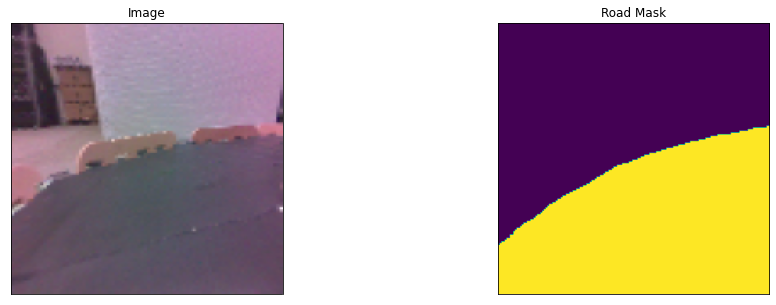

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'gt_train')


x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'gt_valid')

dataset = Dataset(x_train_dir, y_train_dir, classes=['road'])

image, mask = dataset[3] # get some sample
visualize(
    image=image.squeeze(), 
    road_mask=mask.squeeze(),
)

In [ ]:
image.shape

(160, 160, 3)

In [ ]:
def preprocess(image):
    image = Image.fromarray(image)
    image = transforms.functional.to_tensor(image)#.to(device).half()
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

In [ ]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0.0, shift_limit=0.1, p=.5, border_mode=0),

        #albu.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=False),

        albu.GaussNoise(p=0.1),
        albu.Perspective(p=0.1),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(width, height)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

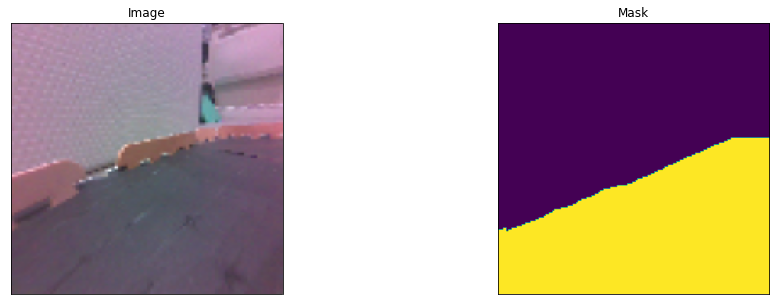

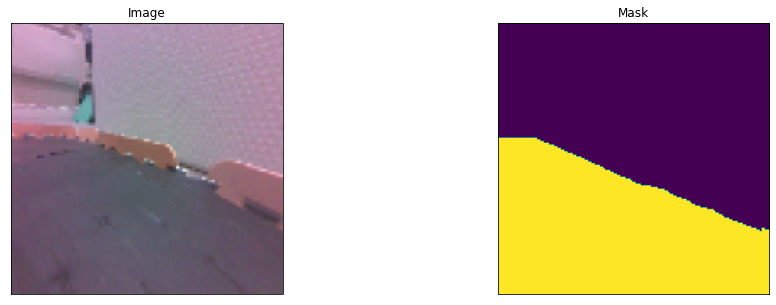

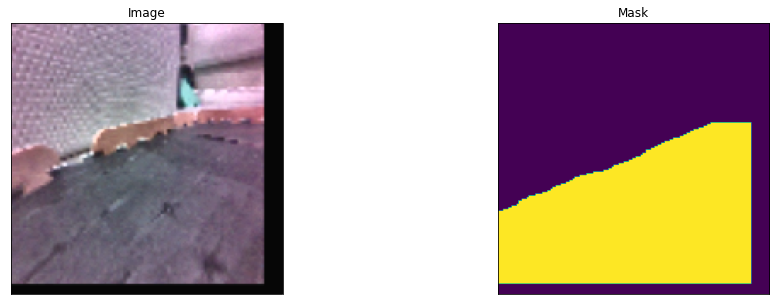

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['road'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

In [ ]:
mask.shape

(160, 160, 1)

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

The model chosen for this task is 'timm-mobilenetv3_small_minimal_100' It is about 0.5MB in size which is good size too work with the Jetson Nano board.  

In [ ]:
ENCODER = 'timm-mobilenetv3_small_minimal_100'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['road']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cpu'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    #encoder_depth=4,
    encoder_weights=ENCODER_WEIGHTS, 
    decoder_pyramid_channels=128,
    classes=len(CLASSES), 
    activation=ACTIVATION,
    #upsampling = 2,
    #in_channels= 1,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_minimal_100-922a7843.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_minimal_100-922a7843.pth


  0%|          | 0.00/7.88M [00:00<?, ?B/s]

In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    #augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
 #Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs
#model = torch.load('./best_model.pth')
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-6
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s, dice_loss - 0.2403, iou_score - 0.6225]
Model saved!

Epoch: 1
valid: 100%|██████████| 6/6 [00:00<00:00, 11.63it/s, dice_loss - 0.2422, iou_score - 0.6151]

Epoch: 2
valid: 100%|██████████| 6/6 [00:00<00:00, 11.63it/s, dice_loss - 0.2389, iou_score - 0.6179]

Epoch: 3
valid: 100%|██████████| 6/6 [00:00<00:00, 11.32it/s, dice_loss - 0.239, iou_score - 0.6181]

Epoch: 4
valid: 100%|██████████| 6/6 [00:00<00:00, 12.20it/s, dice_loss - 0.2338, iou_score - 0.6236]
Model saved!

Epoch: 5
valid: 100%|██████████| 6/6 [00:00<00:00, 11.31it/s, dice_loss - 0.2283, iou_score - 0.63]
Model saved!

Epoch: 6
valid: 100%|██████████| 6/6 [00:00<00:00,  9.44it/s, dice_loss - 0.2249, iou_score - 0.6344]
Model saved!

Epoch: 7
valid: 100%|██████████| 6/6 [00:00<00:00, 10.81it/s, dice_loss - 0.226, iou_score - 0.6328]

Epoch: 8
valid: 100%|██████████| 6/6 [00:00<00:00, 11.43it/s, dice_loss - 0.23, iou_score - 0.6275]

Epoch: 9
valid: 100%|██████████| 6/6

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    #augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(valid_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 6/6 [00:00<00:00, 16.83it/s, dice_loss - 0.2193, iou_score - 0.6412]


In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [ ]:
for i in range(3):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    image = np.transpose(image, (1,2,0))
    image = cv2.resize(image, (width, height))
    image = np.transpose(image, (2,0,1))
    gt_mask = np.transpose(gt_mask, (1,2,0))
    gt_mask = cv2.resize(gt_mask, (width, height))
    #gt_mask = np.expand_dims(gt_mask[:,:,0], axis = 0)

    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

Now you are in the right shape. The rest of the work will be directly on the Jetbot. We will need to upload the model that we just trained on the Jetbot. We will need also to insall the **segmentation-models-pytorch** on Jetbot.